In [1]:
import numpy as np # for everything
import matplotlib.pyplot as plt # for the plots
from scipy.integrate import solve_ivp # for the ODE solver
from scipy.spatial.distance import cdist # for the distance filter
import csv # for write to csv

In [2]:
# You have to right click on the shared folder and do Organize > Add Shortcut > My Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


**PARAMTERS**

If your name is not Billy and you want to change the behavior of this code, the numbers you are looking for are probably here.

I suggest setting all your parameters except num_sim first and do a preliminary run with num_sim set to 100 or 200 so you can get a sense of what your acceptance rate will be (and also what your time per instance will be). Then, divide your desired post-filtered simulation number by that acceptance rate to get the pre-filter num_sim.

In [3]:
# Simulation parameters
dt = 1e-4 # timestep of simulation
num_steps = 200*int(1e2) # total number of steps to simulate; t_final = num_steps * dt

G = 0.5 # gravitational parameter (set as 1 for now since everthing is non-dimensionalized)
num_sim = 19460  # Number of initial conditions to generate (prior to filtering)
# set as (target num_sim) // (expected acceptance rate)

The acceptance rate is ~85%. The rest will get filtered out. so make this number bigger to compenstate.

also the filtering might intoduce some biases into the data. Not sure if it'll matter.

@ v_max = 2, num_steps = 100:
- setting num_sim = 1000 takes 20 seconds to filter with a 0.851 acceptance rate
- setting num_sim = 12000 takes 4.5 minutes to filter with a 0.852 acceptance rate

@ v_max = 2, num_steps = 200:
- num_sim = 100 takes 7 seconds to filter with a 0.750 acceptance rate
- num_sim = 13500 takes __ to filter with a 0.780 acceptance rate

----------------------------------(optimizations)---------------------------

@ v_max = 2, num_steps = 200:
- 0.850 acceptance rate

@ v_max = 1, num_steps = 200:
- num_sim = 1000 takes 2.0 minutes to filter with a 0.598 acceptance rate
- num_sim = 16750 takes 31.0 minutes with a 0.589 acceptance rate

setting initial velocity to zero and num steps to 500 results in a 0.04 acceptance rate. halving sim_step and doubling sim time produces the same acceptance rate.

**INITIALIZATION FUNCTION**

In [4]:
def initialize_3_random_particles(G, v_range, seed):
  # Set a seed for reproducibility
  rng = np.random.default_rng(seed=seed)

  dimension = 2  # 2D space
  num_particles = 3 # don't change this. exists for readibility

  # equal masses
  masses = np.ones(num_particles) # equal masses

  # Random wiggled masses # this sorta breaks the generalizability concept but it might help in isolating G
  # mass_variation_range = 0.1
  # masses = masses + np.random.uniform(-mass_variation_range, mass_variation_range, num_particles)
  # masses[-1] = num_particles - np.sum(masses[0:-1])

  x1 = np.array([1, 0]) # first particle always locationed at (1,0)

  # Ensure that ||x1|| = 1 > ||x3|| > ||x2||, if not, regenerate and check again
  out_spec = True
  while out_spec:
    # Randomly situate x2 in the unit semicircle in the negative x, positive y quadrant
    theta = rng.uniform(0.5 * np.pi, np.pi)
    r = np.sqrt(rng.uniform(0, 1))

    # Calculate coordinates for x2 based on polar coordinates
    # x2 is the closest to the origin and defines the orientation of the y-axis
    x2 = np.array([r * np.cos(theta), r * np.sin(theta)])

    x3 = -1 * (masses[0]*x1 + masses[1]*x2) / masses[2] # This was outside of the while loop
    # x3_alt = -1 * (x1 + x2) # WARNING: THIS ONLY WORKS FOR THE EQUAL MASS CASE

    if np.linalg.norm(x2) < np.linalg.norm(x3) < 1: # to preserve generalizability
      out_spec = False

  positions = np.vstack([x1, x2, x3])

  # Random velocities
  v_angles = rng.uniform(0, 2 * np.pi, num_particles)
  velocities_magnitude = rng.uniform(v_range[0], v_range[1], num_particles)
  vx = velocities_magnitude * np.cos(v_angles)
  vy = velocities_magnitude * np.sin(v_angles)
  velocities = np.column_stack((vx, vy))

  # Ensure total momentum is zero
  momenta = masses[:, np.newaxis] * velocities
  velocities[-1, :] = - np.sum(momenta, axis=0) / masses[-1]

  # Flatten and concatenate positions, masses, and velocities
  initial_condition = np.concatenate((masses, positions.flatten(), velocities.flatten()), axis = 0)

  return initial_condition

generate randomized initial conditions

* $\theta_{2} \in [\pi/2, \pi]$ becasue

  * if $\theta_{2} \in [0, \pi/2]$, all $x_3 > 1$ which breaks our convention of making $x_1$ the furthest point

In [5]:
seed = 42
rng_master = np.random.default_rng(seed)
seeds = rng_master.integers(10000, size=num_sim) # use a seed to randomly gnenerate seeds

v_max = 1 # max value of speed used in IC generation function

# Calculated parameters
initial_conditions = [initialize_3_random_particles(G, [0, v_max], seeds[i]) for i in range(num_sim)]
dim = int((np.shape(initial_conditions)[1]-3)/(2*3)) # num of dimensions

plot initial points

(19460, 15)


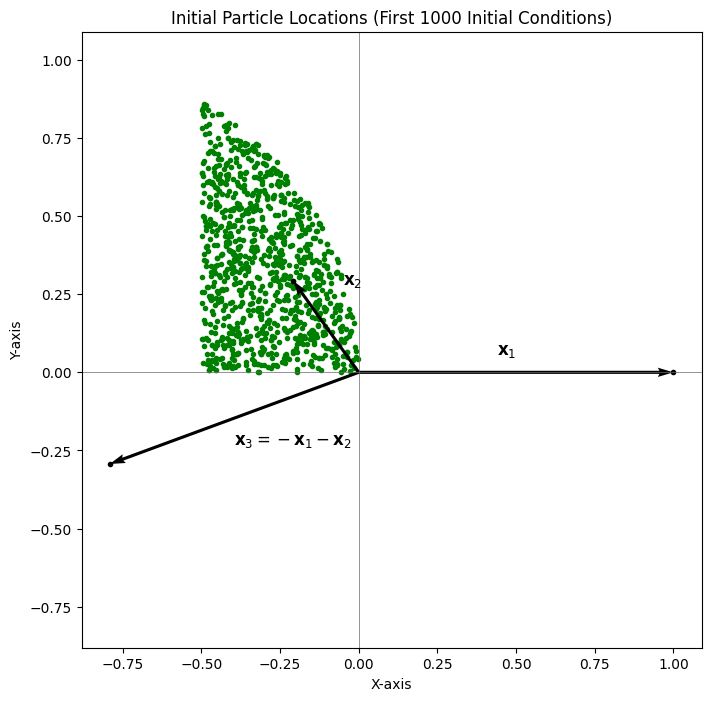

In [6]:
# Plot initial Particle Locations

print(np.array(initial_conditions).shape)
plt.figure(figsize=(8, 8))

# Iterate over the first n initial conditions
n = 1000
for i, initial_condition in enumerate(initial_conditions[:min(n,num_sim)]):
    pos = initial_condition[3:-6].reshape((3, dim))
    x = pos[:,0]
    y = pos[:,1]

    plt.scatter(x[1], y[1], marker='.', color='green')
    # plt.scatter(x[2], y[2], marker='x', color='blue'') # not really necessary

# ----------------------------------------
# Over-lay with a plot of the initial condition that you want to add vectors to
demo_idx = 20 # index of the 'demonstration' case
color = 'black'
demo_ic = initial_conditions[demo_idx]
pos = demo_ic[3:-6].reshape((3, dim))
x = pos[:,0]
y = pos[:,1]
plt.scatter(x[0], y[0], marker='.', color=color)
plt.scatter(x[1], y[1], marker='.', color=color)
plt.scatter(x[2], y[2], marker='.', color=color)

# Over-lay vectors
origin = np.zeros_like(x)
plt.quiver(origin, origin, x, y, color=color, scale=1, scale_units='xy', angles='xy', width=0.005)

# Add labels next to each vector
plt.text(0.5*x[0], 0.5*y[0] + 0.1, r'$\mathbf{x}_1$', fontsize=12, ha='right', va='top')
plt.text(0 + 0.01, y[1], r'$\mathbf{x}_2$', fontsize=12, ha='right', va='center')
plt.text(0.5*x[2], 0.5*y[2] - 0.1, r'$\mathbf{x}_3 = -\mathbf{x}_1 - \mathbf{x}_2$', fontsize=12, ha='left', va='bottom')
# ----------------------------------------

# Set plot limits
plt.ylim(plt.xlim())

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Initial Particle Locations (First {n} Initial Conditions)')

# Draw lines for the x-axis and y-axis
plt.axhline(0, color='dimgray', linewidth=0.5)
plt.axvline(0, color='dimgray', linewidth=0.5)

plt.show()

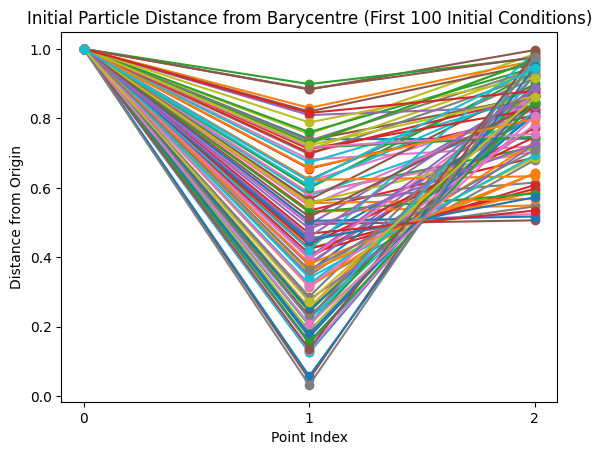

In [7]:
# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Iterate over the first n initial conditions
n = 100
for i, initial_condition in enumerate(initial_conditions[:min(n,num_sim)]):
    # Extract the positions
    pos = initial_condition[3:-6].reshape((3, dim))
    x = pos[:, 0]
    y = pos[:, 1]

    # Calculate distance from each point to the origin
    r = np.sqrt(x**2 + y**2)
    ax.plot(r, marker='o', label=f'Initial Condition {initial_condition}')

ax.set_xlabel('Point Index')
ax.set_ylabel('Distance from Origin')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.title(f'Initial Particle Distance from Barycentre (First {n} Initial Conditions)')
plt.show()

**SIMULATION FUNCTIONS**

In [8]:
def accelerations(positions, mass, G):
  # A function to calculate the derivatives of x, y, and z
  #   given 3 object and their locations according to Newton's laws
  #   vectorization of the gravitational acceleration field
  #
  # Should work with any number of dimensions (2d or 3d)
  # ---------------------------------------------------------------------------
  dim = int(len(positions)/len(mass))
  q = positions.reshape((int(len(positions)/dim), dim))
  q = q.T
  Dq = - q[:, :, np.newaxis] + q[:, np.newaxis, :]    # dist vectors between each particle
  D = np.linalg.norm(Dq, axis = 0) + np.identity(Dq.shape[1]) # norm of the distance vectors between each particle
  D = 1/D
  D = D - np.identity(D.shape[1])     # exclude self
  D = G * mass[:, np.newaxis].dot(mass[np.newaxis, :]) * D**3 # column times row times elemntwise # should G be neg??
  Dq = D * Dq
  Dq = Dq.sum(axis=-1) / mass[np.newaxis,:]
  Dq = Dq.T
  return Dq.reshape((1, q.shape[0]*q.shape[1]))[0]  # sum the matrix along the last dimension, i.e. a tensor contraction along the third index

def f(t, y, masses, G):
  # vectorized right-hand side of the Newtonian ODEs
  n = int(len(y)*0.5) # length of position vector
  positions = y[0:n]
  velocities = y[n:]
  return np.concatenate( ( velocities,  accelerations(positions, masses, G) ))

def simulate_orbital_motion(G, initial_conditions, d_t, n_steps):
  ### This is the main "simulation' function"
  # INPUTS:
  # * G = gravitational parameter
  # * initial_conditions = the initial state of the system.  {1x15 row vector}
  #         [m1 m2 m3 x1 y1 x2 y2 x3 y3 v_x1 v_y1 v_x2 v_y2 v_x3 v_y3]
  # * d_t = time duration of each simulation time step, 0 < d_t < 1(usually), {scalar}
  # * n_steps = number of simulaiton time steps, integer > 0 {scalar}
  #
  # OUTPUTS:
  # * pos = an array of the positions of each particale and each time step.
  #         each row is a time step the first row is the inital position.
  #         Each row t = [t, m1, m2, m3, x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]
  #
  # This funtion uses the funtions: f() and accelerations()
  # ---------------------------------------------------------------------------
  t_0 = 0
  t_f = n_steps * d_t
  t_nodes = np.linspace(t_0, t_f, num=n_steps)

  # unpack initial conditions
  masses = initial_conditions[0:3] # always assume that there are 3 particles
  y_initial = initial_conditions[3:]

  # solve ODE
  solution = solve_ivp(fun=lambda t, y: f(t, y, masses, G),
                  t_span=[t_0, t_f],
                  y0=y_initial,
                  t_eval=t_nodes,
                  method='RK45')
  pos = solution.y.T
  # print(solution.message)
  # TODO: pass an integration failure flag instead of measuring output length to detect failure

  time = solution.t[:, None]
  timed_state = np.concatenate([time, np.full_like(time, masses[0]), np.full_like(time, masses[1]), np.full_like(time, masses[2]), pos], axis=1)
  return timed_state


**FILTER FUNCTIONS**

In [9]:
# distance filter
def min_pairwise_distance(positions):
  """
  Calculate pairwise distances between points.

  Parameters:
  - positions: np.array, shape (n_points, 2) - Array containing the x, y coordinates of points.

  Returns:
  - min_distance: scalar
  """
  # Probaly not necessary. only trips for ~ 3/12000
  # Do I even care if they get super close if energy is still preserved?
  # I suppose you can think of this as the diameter of the objects
  # ---------------------------------------------------------------------------
  distances = cdist(positions, positions)
  np.fill_diagonal(distances, np.inf)
  min_distance = np.min(distances)
  return min_distance

# total energy filter
def calculate_mechanical_energy(positions, velocities, masses, G):
  """
  Calculate the mechanical energy of a system.

  Parameters:
  - positions: Array of shape (num_steps, num_particles, dim) representing particle positions.
  - velocities: Array of shape (num_steps, num_particles, dim) representing particle velocities.
  - masses: Array of shape (num_particles,) representing particle masses.
  - G: Gravitational constant.

  Returns:
  - Total mechanical energy.
  """
  num_steps, num_particles, dim = positions.shape

  # Calculate kinetic energy
  kinetic_energy = 0.5 * np.sum(masses * np.linalg.norm(velocities, axis=-1)**2, axis=-1)

  # Calculate potential energy
  potential_energy = 0.0
  for i in range(num_particles):
      for j in range(i + 1, num_particles):
          r = positions[:, i, :] - positions[:, j, :]
          r_norm = np.linalg.norm(r, axis=-1)
          potential_energy += - G * masses[i] * masses[j] / r_norm

  return kinetic_energy + potential_energy

**FILTERING LOOP**

re-run this after any changes to parameters

In [10]:
# Set hyperparameters
threshold_dist = 0.001 # if two particles get closer than this distance, it will be considered a collision. Basically the diam of the objects as a fraction of their max starting radius
energy_threshold = 0.1 # margin of error on energy conservation constraint (as a fraction of initial system energy)

# Initialize arrays
results = np.zeros((num_sim, len(initial_conditions[0]) + 1))
energy_pd = np.zeros((num_sim, num_steps)) # store the percentage diff of system energy

# Perform simulations and apply filters
for i, initial_condition in enumerate(initial_conditions):

    # Perform simulation for simulate_orbital_motion
    states = simulate_orbital_motion(G, initial_condition, dt, num_steps)
    positions_over_time_flat = states[:,4:-6]
    velocities_over_time_flat = states[:,-6:]

    # Check shape
    if len(positions_over_time_flat) < num_steps:
      # If shapes are not as expected, consider it a failure and skip to the next iteration
      # This happens when the ODE solver terminates early due to small integration steps
      #   Typically this happens when the points start in a weird spot (e.g. x2[0] = -0.5)
      # Pad the remaining steps with copies of the last step
      positions_over_time_flat = np.tile(positions_over_time_flat[-1, :], (num_steps, 1))
      velocities_over_time_flat = np.tile(velocities_over_time_flat[-1, :], (num_steps, 1))
      results[i, :] = np.concatenate((initial_condition, [-1]))
      continue

    results[i, :] = np.concatenate((initial_condition, [0]))


    # Reshape for comparison
    positions_over_time = positions_over_time_flat.reshape((num_steps, 3, dim)) # has to be a seperate line b/c of sim failures
    velocities_over_time = velocities_over_time_flat.reshape((num_steps, 3, dim))

    # 1. Check min distance
    # min_dist2 = np.array([min_pairwise_distance(positions) for positions in positions_over_time])
    # out = np.less(min_dist2, threshold_dist*np.ones([num_steps,1]))
    # out2 = np.any(out, axis=1, keepdims=True).astype(int)
    # results[i, :] = np.concatenate((initial_condition,out2[-1])) # label collisions or passed
    # debug: this is probably why removing the distance filter breaks the code. it reassigns the last column differently

    # 2. Vectorized energy calculation
    energy = calculate_mechanical_energy(positions_over_time, velocities_over_time, initial_condition[0:3], G)
    init_energy = energy[0] # find the total energy in the system at t0
    energy_pd_step = abs((energy - init_energy) / init_energy) # relative error
    energy_violations = np.greater(energy_pd_step, energy_threshold)

    if energy_violations.any():
      results[i, -1] = 3
    energy_pd[i, :] = energy_pd_step

# Organize results
collided = results[results[:, -1] == 1, :-1]
energy_violators = results[results[:, -1] == 3 , :-1]
passed = results[results[:, -1] == 0, :-1]
failures = results[results[:, -1] == -1, :-1]

# Print results
print(f"Number of collisions (only): {len(collided)}")
print(f"Number of energy violators: {len(energy_violators)}")
print(f"Number passed: {len(passed)}")
print(f"Number of failures: {len(failures)}")
print(f"\nAcceptance rate: {len(passed)/num_sim:.3f}")

Number of collisions (only): 0
Number of energy violators: 6460
Number passed: 12748
Number of failures: 252

Acceptance rate: 0.655


**PLOTTING**

1. (optional) Plot all simulations - with thier classifications from the filtering loop.

For some reason, if I remove the distance filter (even when it does not catch anything) I get a divide by zero error bellow???

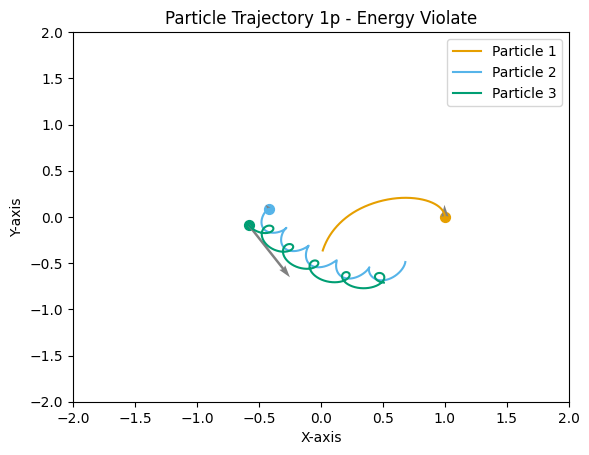

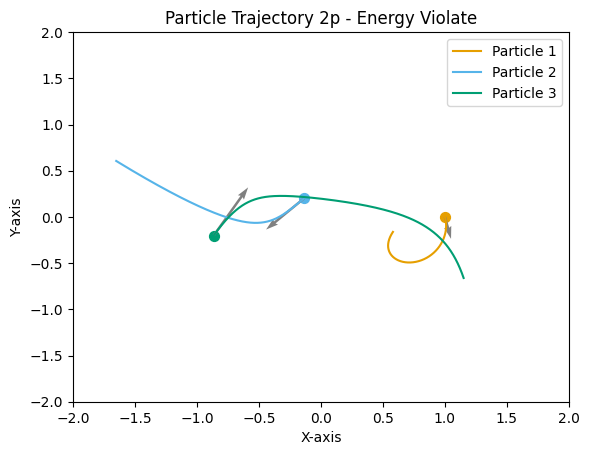

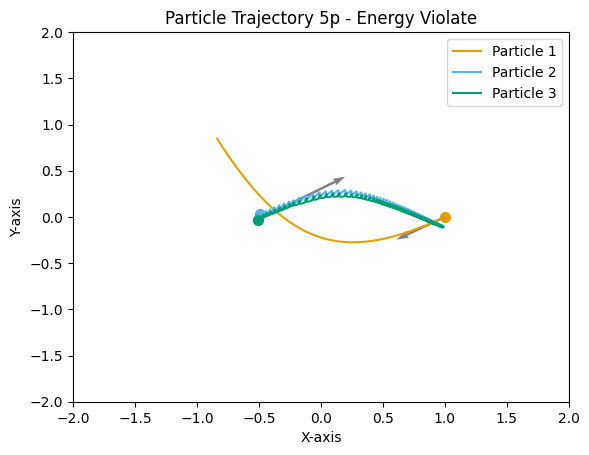

In [11]:
# Plot the first n results and their classifications
target_group = 3 # set to None to plot all

n = 10
for i, row in enumerate(results[:min(n,len(results))]):
    result_label = "Pass" if row[-1] == 0 else \
                   "Collision" if row[-1] == 1 else \
                   "Overspeed" if row[-1] == 2 else \
                   "Energy Violate" if row[-1] == 3 else \
                   "Failure"  # Assuming -1 is for failure
    if row[-1] == target_group or target_group == None:
      initial_condition = row[:-1]  # Exclude the last column
      # Perform simulation for simulate_orbital_motion
      states = simulate_orbital_motion(G, initial_condition, dt, num_steps)
      positions_over_time_flat = states[:,-12:-6]
      velocities_over_time_flat = states[:,-6:]

      if len(positions_over_time_flat) < num_steps:
          # Pad the remaining steps with copies of the last step
          positions_over_time_flat = np.tile(positions_over_time_flat[-1, :], (num_steps, 1))
          velocities_over_time_flat = np.tile(velocities_over_time_flat[-1, :], (num_steps, 1))

      # Reshape for plotting
      positions_over_time = positions_over_time_flat.reshape((num_steps, 3, dim))
      velocities_over_time = velocities_over_time_flat.reshape((num_steps, 3, dim))
      initial_velocities = velocities_over_time[0]

      # Plot
      colors = ['#E69F00', '#56B4E9', '#009E73']
      ax_lim = 2
      plt.figure()  # Create a new figure for each simulation
      for particle_number in range(3):
        x = positions_over_time[:, particle_number, 0]
        y = positions_over_time[:, particle_number, 1]
        color = colors[particle_number]
        plt.plot(
              x, y,
              color=color,
              label=f'Particle {particle_number + 1}'
        )
        plt.scatter(x[0], y[0], s=50, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')

        # Plot initial velocity vectors
        vx, vy = initial_velocities[particle_number]
        plt.quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)

        plt.xlim([-ax_lim, ax_lim])
        plt.ylim([-ax_lim, ax_lim])

      plt.title(f'Particle Trajectory {i}p - {result_label}') # p for "pre-filter"
      plt.xlabel('X-axis')
      plt.ylabel('Y-axis')
      plt.legend()
      plt.show()

3. Plots of the change in total mechanical energy in each system. This is calculated as the difference between the energy at each time step and the initial energy, and is then multiplied by the initial energy.
The first plot shows all the changes over time; the second is a histogram of the maximum value of the changes for each simulation.

<ipython-input-12-bca844118f3f>:17: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


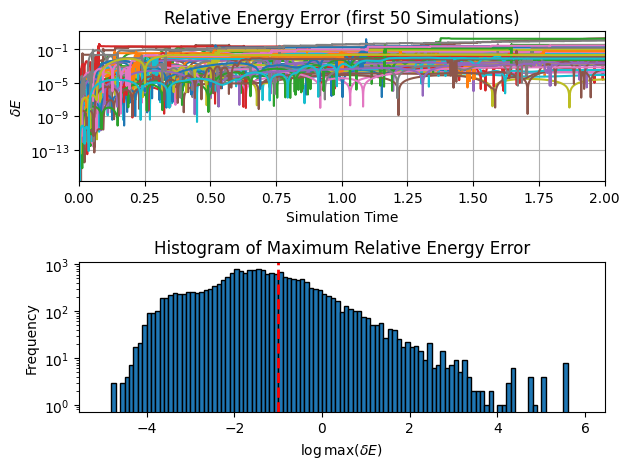

In [12]:
# Plot the relative error in total mechanical energy for first n simulations
fig, axs = plt.subplots(2, 1, tight_layout=True)

n = 50
for i in range(min(n,num_sim)):
    axs[0].semilogy(np.arange(num_steps) * dt, energy_pd[i, :], label=f"Simulation {i}")

axs[0].set_title(f'Relative Energy Error (first {n} Simulations)')
axs[0].set_xlabel('Simulation Time')
axs[0].set_ylabel('$\delta E$')
axs[0].set_xlim([0,num_steps * dt])
axs[0].grid(True)

# Plotting histogram of maximum energy errors for first n simulations
n = num_sim # Option to make this smaller
data = np.max(energy_pd, axis=1)
data = np.log10(data)
data = data[:n]

bin_edges = np.arange(-5, np.ceil(max(data)), 0.1)
hist, bin_edges = np.histogram(data, bins=bin_edges)
axs[1].hist(data, bins=bin_edges, edgecolor='black')
axs[1].axvline(x=np.log10(energy_threshold), color='red', linestyle='--', linewidth=2, label='Boundary at x=1')
axs[1].set_yscale('log')
axs[1].set_title(f'Histogram of Maximum Relative Energy Error')
axs[1].set_xlabel('$\log \max(\delta E)$')
axs[1].set_ylabel('Frequency')

plt.show()

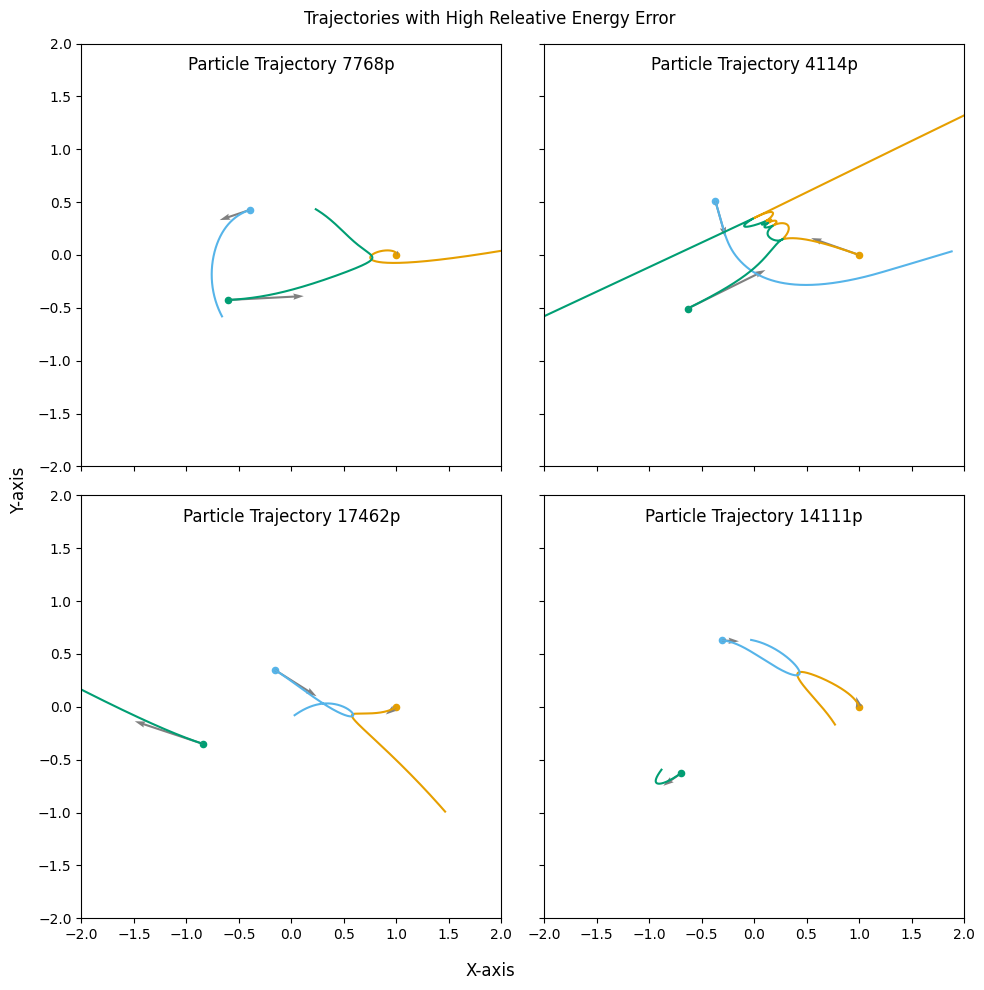

In [13]:
# Plot Energy Violators

target_group = 3
Idx_of_tg = [i for i, row in enumerate(results) if row[-1] == target_group] # list of the indices of the target group

# Set a seed for reproducibility
rng_plot = np.random.default_rng(seed=18)

# Randomly select rows from 'passed'
random_indices = rng_plot.choice(Idx_of_tg, size=4, replace=False)  # size = 4 so we can do a 2x2 grid
# selected_indices = np.concatenate((random_indices, [101], [223], [43])) # easy to hand pick later if you'd like
selected_indices = random_indices

# Plot the associated rows in results
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex='all', sharey = 'all')
axs = axs.flatten()

for i, selected_index in enumerate(selected_indices):
    row = results[selected_index]
    initial_condition = row[:-1]  # Exclude the last column

    # Perform simulation for simulate_orbital_motion
    states = simulate_orbital_motion(G, initial_condition, dt, num_steps)
    positions_over_time_flat = states[:, -12:-6]
    velocities_over_time_flat = states[:,-6:]

    if len(positions_over_time_flat) < num_steps:
        # Pad the remaining steps with copies of the last step
        positions_over_time_flat = np.tile(positions_over_time_flat[-1, :], (num_steps, 1))

    # Reshape for plotting
    positions_over_time = positions_over_time_flat.reshape((num_steps, 3, dim))
    velocities_over_time = velocities_over_time_flat.reshape((num_steps, 3, dim))
    initial_velocities = velocities_over_time[0]

    # Plot
    colors = ['#E69F00', '#56B4E9', '#009E73']
    ax_lim = 2
    for particle_number in range(3):
      x = positions_over_time[:, particle_number, 0]
      y = positions_over_time[:, particle_number, 1]
      color = colors[particle_number]
      axs[i].plot(
            x, y,
            color=color, label=f'Particle {particle_number + 1}'
      )
      axs[i].scatter(x[0], y[0], s=20, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')

      # Plot initial velocity vectors
      vx, vy = initial_velocities[particle_number]
      axs[i].quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)

      axs[i].set_xlim([-ax_lim, ax_lim])
      axs[i].set_ylim([-ax_lim, ax_lim])

    axs[i].set_title(f'Particle Trajectory {selected_indices[i]}p', y=0.95, va='top')
fig.supxlabel('X-axis')
fig.supylabel('Y-axis')
fig.suptitle('Trajectories with High Releative Energy Error')

plt.tight_layout()
plt.show()

**RESULTS**

Run this code to get the array of all the states of all simulations at all the timesteps. It's not necessary to re-run this and calculate them again. I should change that.

It also displays some information that can be helpful for a final sanity check and to see formatting.

In [14]:
print('First member in list of initial conditions:')
print(np.array(passed)[0])
print('Size of array of initial values: ', np.shape(passed))

# Arrays to store results
states_all = np.zeros((passed.shape[0], num_steps, dim*3*2+4))

# Perform simulations and check average distance
for i, initial_condition in enumerate(passed):

    # Perform simulation for simulate_orbital_motion
    positions_over_time = simulate_orbital_motion(G, initial_condition, dt, num_steps)

    states_all[i, : , :] = np.copy(positions_over_time)
print('Size of states_all array: ', np.shape(states_all))

# output: states_all

First member in list of initial conditions:
[ 1.          1.          1.          1.          0.         -0.49870975
  0.546423   -0.50129025 -0.546423   -0.66514838  0.18937576 -0.88592967
  0.24021671  1.86527017 -0.6379491 ]
Size of array of initial values:  (12748, 15)
Size of states_all array:  (12748, 20000, 16)


2. Plot a randomly selected set of the initial conditions

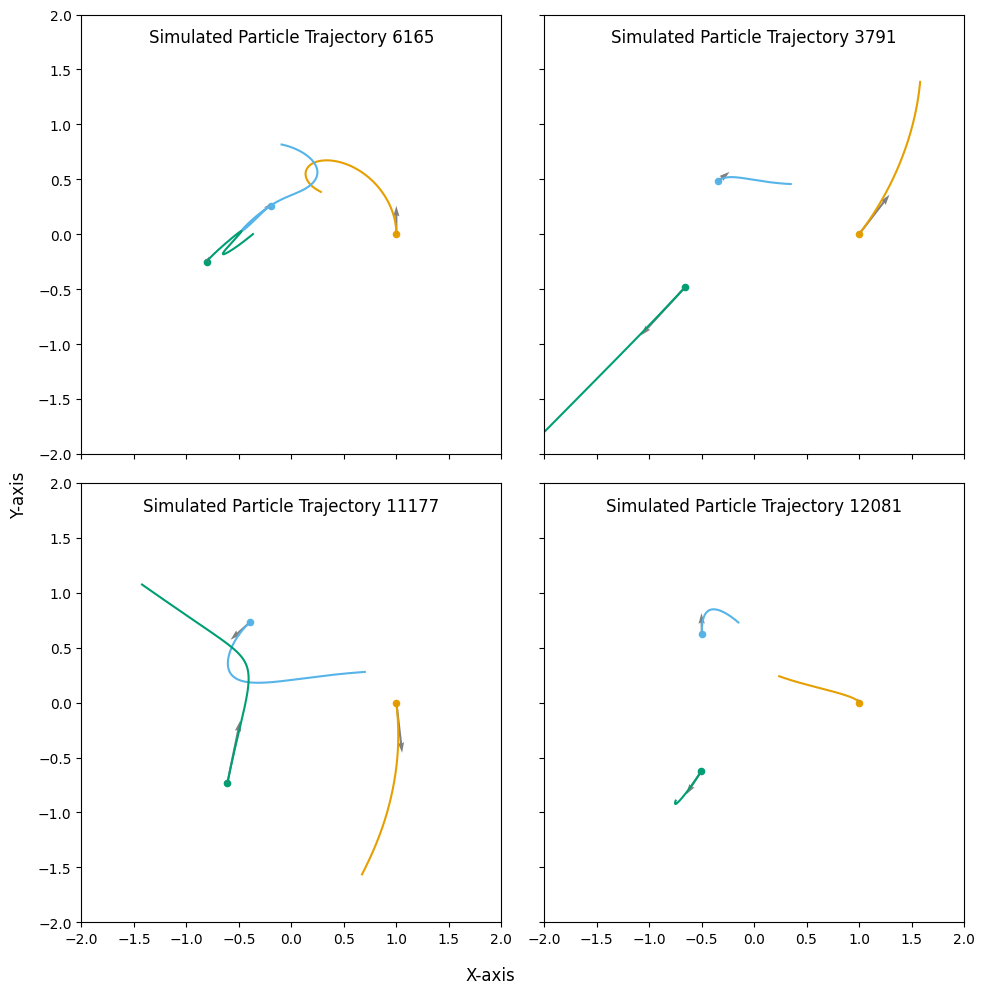

In [15]:
# Co plot 4 random simulations

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex='all', sharey = 'all')
axs = axs.flatten()

# Set a seed for reproducibility
rng_plot = np.random.default_rng(seed=42069)

# Randomly select rows from 'passed'
random_indices = rng_plot.choice(len(passed), size=4, replace=False)  # size = 4 so we can do a 2x2 grid
selected_rows = states_all[random_indices,0,:] # use the same random indicies from above

# Add a column for random indices
selected_rows_with_indices = np.column_stack((selected_rows, random_indices))

# Perform simulations and plot trajectories for both functions
for i, row in enumerate(selected_rows_with_indices):
  idx = int(row[-1]) # index from full list of initial conditions

  states = states_all[idx,:,1:] # remove time column (not really necessary)
  positions_over_time_flat = states[:,-12:-6]
  velocities_over_time_flat = states[:,-6:]

  # Reshape for plotting
  positions_over_time = positions_over_time_flat.reshape((num_steps, 3, dim))
  velocities_over_time = velocities_over_time_flat.reshape((num_steps, 3, dim))
  initial_velocities = velocities_over_time[0]

  # Plot
  colors = ['#E69F00', '#56B4E9', '#009E73']
  ax_lim = 2
  for particle_number in range(3):
    x = positions_over_time[:, particle_number, 0]
    y = positions_over_time[:, particle_number, 1]
    color = colors[particle_number]
    axs[i].plot(
          x, y,
          color=color, label=f'Particle {particle_number + 1}'
    )
    axs[i].scatter(x[0], y[0], s=20, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')
    axs[i].set_xlim([-ax_lim, ax_lim])
    axs[i].set_ylim([-ax_lim, ax_lim])

    # Plot initial velocity vectors
    vx, vy = initial_velocities[particle_number]
    axs[i].quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)

  axs[i].set_title(f'Simulated Particle Trajectory {idx}', y=0.95, va='top')
fig.supxlabel('X-axis')
fig.supylabel('Y-axis')
plt.tight_layout()
plt.show()

**EXPORT RESULTS TO CSV**

In [16]:
# Write to csv
sim_filename = f'simulated_dataset-{seed}_G={G}_sumSteps={num_steps}.csv'
sim_folder_location = '/content/drive/My Drive/EC523 Final Project/Data/Experimental/'
sim_file_path = sim_folder_location + sim_filename
shape = np.shape(states_all)
states_all_2d = states_all.reshape((shape[0] * shape[1], shape[-1]))
with open(sim_file_path,"w+") as my_csv:
  newarray = csv.writer(my_csv,delimiter=',')
  newarray.writerows(states_all_2d)

In [17]:
print(sim_file_path)

/content/drive/My Drive/EC523 Final Project/Data/Experimental/simulated_dataset-42_G=0.5_sumSteps=20000.csv


ATTENTION: Copy and paste the block below into your code (make sure you are mounted to Drive and have the folder set up). Also, make sure to define the num_steps in your code (it should be specified in the file name of the .csv you are reading) - this is the only parameter from this file you need to know to interpret the results. You will probably have to edit the file location

formating for each simulation:

row_t = ['t', 'm1', 'm2', 'm3', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'vx1', 'vy1', 'vx2', 'vy2', 'vx3', 'vy3']

or, more legibly:
$$
\mathbf{row}_t = [t, m_1, m_2, m_3, x_1, y_1, x_2, y_2, x_3, y_3, v_{x1}, v_{y1}, v_{x2}, v_{y2}, v_{x3}, v_{y3}]
$$



In [ ]:
# Read from csv
# TODO: seperate out the folder location and filename into seperate variables for ease of use
with open(sim_file_path, 'r') as csvfile:
  states_read_2d = np.array(list(csv.reader(csvfile))).astype(float)  # Convert to floatsprint('Size of states_read_2d array: ', np.shape(states_read_2d))
# To read this, you need to know num_steps (scroll up to parameters section to confirm)
num_sim_derived = (states_read_2d.size) // (num_steps * states_read_2d.shape[-1])
states_all_read = states_read_2d.reshape((num_sim_derived, num_steps, states_read_2d.shape[-1]))

ic_all_read = states_all_read[:,0,1:] # just the initial state of every simulation (without the time column)


In [ ]:
# check that the read array is the same as the written
print(f'Is states_all_reshaped the same as states_all? {np.array_equal(states_all, states_all_read)}')

(optional) Plot some of the results to further confirm the 3D to 2D to 3D conversion worked correctly

In [ ]:
# Choose which state array to use to make sure they're all the same
# state_array = states_all
# state_array = states_all_reshaped
state_array = states_all_read

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex='all', sharey = 'all')
axs = axs.flatten()

selected_rows = state_array[random_indices,0,:] # use the same random indicies from above

# Add a column for random indices
selected_rows_with_indices = np.column_stack((selected_rows, random_indices))

# Perform simulations and plot trajectories for both functions
for i, row in enumerate(selected_rows_with_indices):
  idx = int(row[-1]) # index from full list of initial conditions

  states = state_array[idx,:,1:] # remove time column (not really necessary)
  positions_over_time_flat = states[:,-12:-6]
  velocities_over_time_flat = states[:,-6:]

  # Reshape for plotting
  positions_over_time = positions_over_time_flat.reshape((num_steps, 3, dim))
  velocities_over_time = velocities_over_time_flat.reshape((num_steps, 3, dim))
  initial_velocities = velocities_over_time[0]

  # Plot
  colors = ['#E69F00', '#56B4E9', '#009E73']
  ax_lim = 2
  for particle_number in range(3):
    x = positions_over_time[:, particle_number, 0]
    y = positions_over_time[:, particle_number, 1]
    color = colors[particle_number]
    axs[i].plot(
          x, y,
          color=color, label=f'Particle {particle_number + 1}'
    )
    axs[i].scatter(x[0], y[0], s=20, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')
    axs[i].set_xlim([-ax_lim, ax_lim])
    axs[i].set_ylim([-ax_lim, ax_lim])

    # Plot initial velocity vectors
    vx, vy = initial_velocities[particle_number]
    axs[i].quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)

  axs[i].set_title(f'Simulated Particle Trajectory {idx}', y=0.95, va='top')
fig.supxlabel('X-axis')
fig.supylabel('Y-axis')
plt.tight_layout()
plt.show()